# Prosper借贷分析（二）
## 生成用户信用评级模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 载入数据集
df = pd.read_csv('prosper_data_cos.csv')

# 查看数据集特征
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 19 columns):
ProsperRating..Alpha.                 84853 non-null object
Occupation                            110349 non-null object
EmploymentStatus                      111682 non-null object
EmploymentStatusDuration              106312 non-null float64
IsBorrowerHomeowner                   113937 non-null bool
CurrentlyInGroup                      113937 non-null bool
GroupKey                              13341 non-null object
IncomeRange                           113937 non-null object
IncomeVerifiable                      113937 non-null bool
CreditScoreRangeLower                 113346 non-null float64
CreditScoreRangeUpper                 113346 non-null float64
CurrentCreditLines                    106333 non-null float64
OpenCreditLines                       106333 non-null float64
TotalInquiries                        112778 non-null float64
CurrentDelinquencies                 

In [3]:
# 删除缺失值过多的特征
df.drop('GroupKey', axis=1, inplace=True)

In [4]:
# 拷贝数据
df_clean = df.copy()

## 数据清洗  

我们发现数据集中有不少数据缺少prosper信用评级，首先就是要将这些数据提取出来。

In [5]:
df_noy = df_clean[df_clean['ProsperRating..Alpha.'].isnull()]

df_noy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29084 entries, 0 to 113927
Data columns (total 18 columns):
ProsperRating..Alpha.                 0 non-null object
Occupation                            26829 non-null object
EmploymentStatus                      26829 non-null object
EmploymentStatusDuration              21478 non-null float64
IsBorrowerHomeowner                   29084 non-null bool
CurrentlyInGroup                      29084 non-null bool
IncomeRange                           29084 non-null object
IncomeVerifiable                      29084 non-null bool
CreditScoreRangeLower                 28493 non-null float64
CreditScoreRangeUpper                 28493 non-null float64
CurrentCreditLines                    21480 non-null float64
OpenCreditLines                       21480 non-null float64
TotalInquiries                        27925 non-null float64
CurrentDelinquencies                  28387 non-null float64
RevolvingCreditBalance                21480 non-null 

数据集中只保留信用评级有记录的条目。  
令人惊喜的是，很多原先有缺失值的条目，都被剔除了！看来可以推测，这些特征和信用评级都具有很强的关系。

In [6]:
df_clean = df_clean[df_clean['ProsperRating..Alpha.'].notnull()]

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84853 entries, 1 to 113936
Data columns (total 18 columns):
ProsperRating..Alpha.                 84853 non-null object
Occupation                            83520 non-null object
EmploymentStatus                      84853 non-null object
EmploymentStatusDuration              84834 non-null float64
IsBorrowerHomeowner                   84853 non-null bool
CurrentlyInGroup                      84853 non-null bool
IncomeRange                           84853 non-null object
IncomeVerifiable                      84853 non-null bool
CreditScoreRangeLower                 84853 non-null float64
CreditScoreRangeUpper                 84853 non-null float64
CurrentCreditLines                    84853 non-null float64
OpenCreditLines                       84853 non-null float64
TotalInquiries                        84853 non-null float64
CurrentDelinquencies                  84853 non-null float64
RevolvingCreditBalance                84853 non-n

## 数据观察

In [7]:
df_clean.sample(10)

,ProsperRating..Alpha.,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,IncomeRange,IncomeVerifiable,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalInquiries,CurrentDelinquencies,RevolvingCreditBalance,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent..percentage.
16097,C,Executive,Employed,127.0,True,False,"$100,000+",True,660.0,679.0,25.0,21.0,10.0,0.0,44992.0,2995.0,56.0,0.98
77522,E,Other,Employed,95.0,False,False,"$25,000-49,999",False,600.0,619.0,16.0,14.0,5.0,0.0,11622.0,2077.0,22.0,0.81
74372,B,Professional,Employed,68.0,False,False,"$75,000-99,999",True,680.0,699.0,10.0,9.0,5.0,0.0,10685.0,9165.0,17.0,0.94
3614,A,Construction,Self-employed,36.0,True,True,"$50,000-74,999",False,740.0,759.0,11.0,11.0,0.0,0.0,17205.0,19595.0,19.0,1.00
22606,E,Professional,Full-time,93.0,False,False,"$75,000-99,999",True,600.0,619.0,15.0,12.0,18.0,0.0,16970.0,5795.0,28.0,1.00
96212,B,Clerical,Employed,273.0,False,False,"$25,000-49,999",True,760.0,779.0,10.0,10.0,0.0,0.0,14606.0,6154.0,29.0,0.96
54952,D,Teacher,Employed,14.0,False,False,"$50,000-74,999",True,700.0,719.0,13.0,13.0,6.0,0.0,27860.0,18340.0,36.0,1.00
35417,A,Realtor,Employed,183.0,True,False,"$75,000-99,999",False,700.0,719.0,36.0,35.0,8.0,0.0,9195.0,22470.0,60.0,0.93
68857,A,Retail Management,Employed,7.0,False,False,"$25,000-49,999",True,740.0,759.0,3.0,3.0,4.0,0.0,960.0,6440.0,7.0,0.87
47852,E,Professional,Full-time,141.0,True,True,"$50,000-74,999",False,640.0,659.0,8.0,8.0,3.0,5.0,5469.0,581.0,14.0,0.80


In [8]:
df_clean.IncomeRange.value_counts()

$50,000-74,999    25627
$25,000-49,999    24175
$100,000+         15205
$75,000-99,999    14498
$1-24,999          4654
Not employed        649
$0                   45
Name: IncomeRange, dtype: int64

In [9]:
df_clean.describe()

,EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalInquiries,CurrentDelinquencies,RevolvingCreditBalance,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent..percentage.
count,84834.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000
mean,103.055320,699.390240,718.390240,10.508032,9.528644,4.290396,0.322452,17940.237576,11400.695355,23.928571,0.905914
std,97.078884,47.095937,47.095937,5.317401,4.931802,3.827574,1.111996,31367.466293,18610.424333,11.607638,0.121353
min,0.000000,600.000000,619.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.080000
25%,30.000000,660.000000,679.000000,7.000000,6.000000,2.000000,0.000000,3824.000000,1148.000000,16.000000,0.850000
50%,74.000000,700.000000,719.000000,10.000000,9.000000,3.000000,0.000000,9323.000000,4574.000000,23.000000,0.950000
75%,148.000000,720.000000,739.000000,13.000000,12.000000,6.000000,0.000000,20339.000000,13910.000000,31.000000,1.000000
max,755.000000,880.000000,899.000000,59.000000,54.000000,78.000000,51.000000,999165.000000,498374.000000,122.000000,1.000000


最长工作时间竟然约为63年！  

## 数据切分

In [10]:
# 切分数据----特征and标签
prosper_rating = df_clean['ProsperRating..Alpha.']

df_clean = df_clean.drop('ProsperRating..Alpha.', axis=1)

**`问题`**  

- Occupation, EmploymentStatusDuration有缺失值。  
- 数值型的特征需要进行特征缩放。  
- IncomeRange, Occupation, EmploymentStatus需要进行独热编码，处理成算法好识别的类型（这里为0和1的数字类型）。 
- IncomeRange在进行独热编码之前需要定义一个更好理解的特征值。  
- 布尔值的特征需要转换成数值类型。  

## 缺失值的处理  

In [11]:
df_clean.Occupation.value_counts()[0:3]

Other           21317
Professional    10542
Executive        3468
Name: Occupation, dtype: int64

In [12]:
# 用Other填充Occupation缺失值
df_clean = df_clean.fillna({'Occupation': 'Other'})

# 用平均值填充EmploymentStatusDuration的缺失值
df_clean = df_clean.fillna({'EmploymentStatusDuration': round(mean(df_clean.EmploymentStatusDuration))})

## 特征处理

In [13]:
# 创建查看数字型特征的特征分布函数
def visuals():
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

    for ax, feature in zip(axes.flat, numeric_features):
        ax.hist(df_clean[feature])
        ax.set_title(feature)

In [14]:
# 创建获取某类别特征的函数
def get_features(ftype):
    features = df_clean.dtypes[df_clean.dtypes == ftype].index.tolist()
    return features

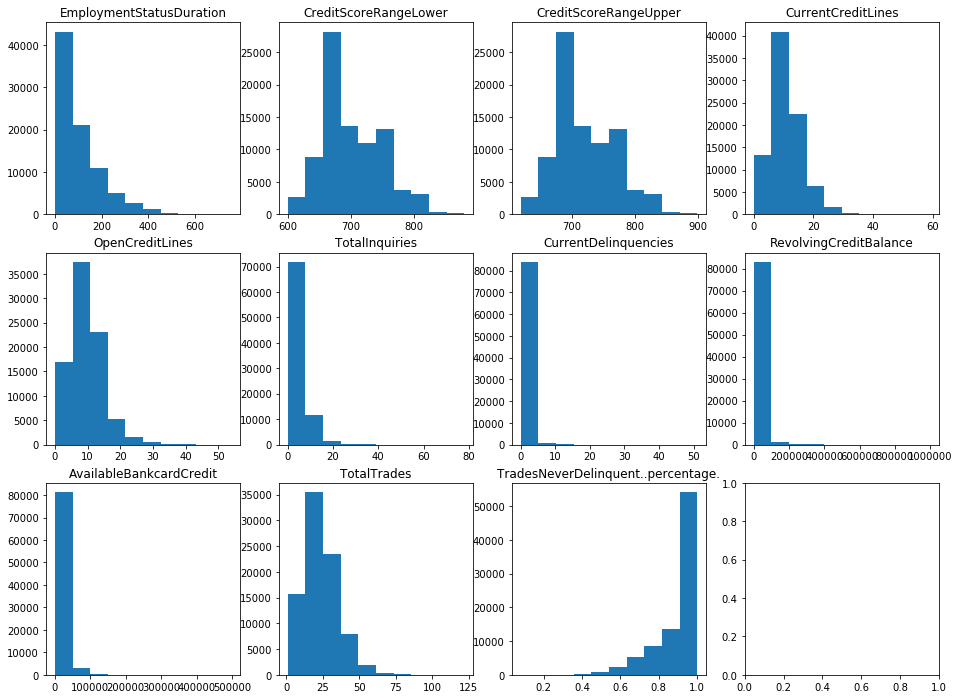

In [15]:
# 得到数字型特征
numeric_features = get_features('float64')

#查看特征分布
visuals()

### 转换倾斜的连续特征

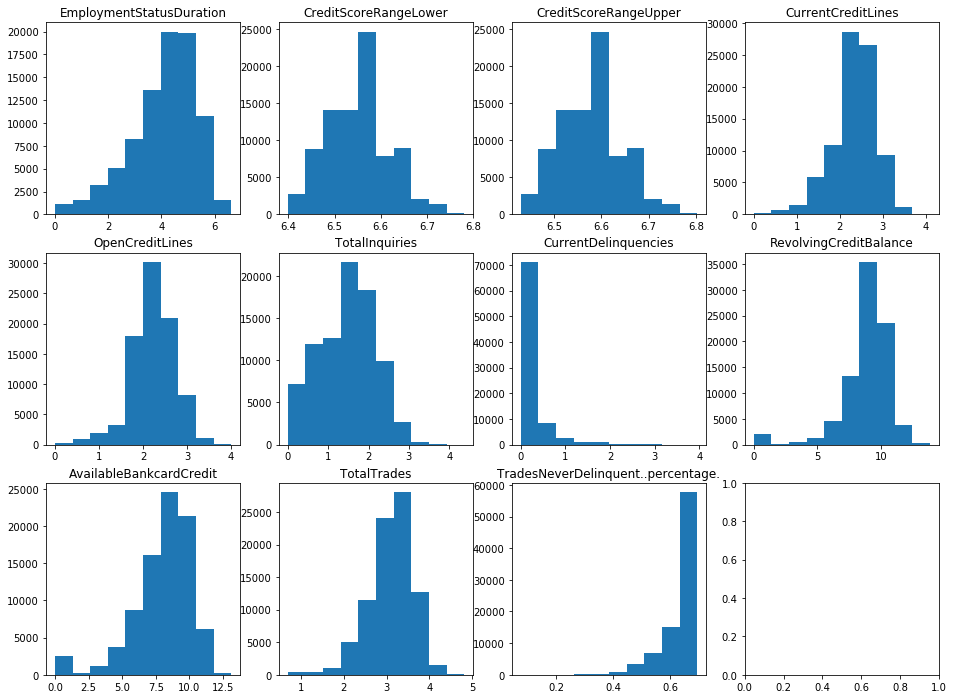

In [16]:
# 进行log转换
# 为避免出现算术错误，特征值统一加1处理
df_clean[numeric_features] = df_clean[numeric_features].apply(lambda x:np.log(x+1))

# 再次查看特征分布
visuals()

可以看到有两个特征依旧很“坚强”，但是其特征原范围确实很小，所以暂时不管。  

### 归一化数字特征

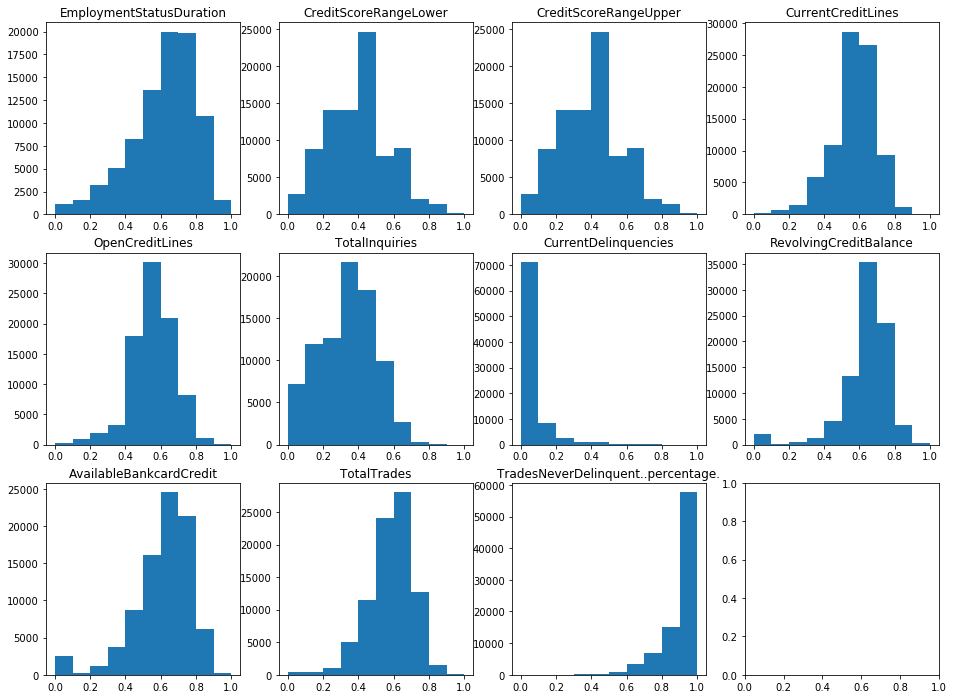

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[numeric_features] = scaler.fit_transform(df_clean[numeric_features])

# 再次查看特征分布
visuals()

可以看到，依旧是转换好的类似正态分布，但是特征范围已经变了。  

### 独热编码

In [18]:
df_clean.IncomeRange = df_clean.IncomeRange.replace({'$0':'Not employed',  # 为了简化特征，统一归类
                                                     '$1-24,999':'Very low',
                                                     '$25,000-49,999':'Low',
                                                     '$50,000-74,999':'Medium',
                                                     '$75,000-99,999':'High',
                                                     '$100,000+':'Very high'})

# 得到str型变量
str_features = get_features('object')

# 独热编码
df_clean= pd.get_dummies(df_clean)

对布尔型变量不用进行独热编码，只要将TRUE->1，FALSE->0即可。

In [19]:
# 得到bool型变量
bool_features = get_features('bool')

# 转换
for feature in bool_features:
    df_clean[feature] = df_clean[feature].apply(lambda x:1 if x else 0)

In [20]:
df_clean.head(10)

,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,IncomeVerifiable,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalInquiries,CurrentDelinquencies,...,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed,IncomeRange_High,IncomeRange_Low,IncomeRange_Medium,IncomeRange_Not employed,IncomeRange_Very high,IncomeRange_Very low
1,0.574327,0,0,1,0.326744,0.325648,0.661412,0.675774,0.410065,0.000000,...,0,0,0,0,0,0,1,0,0,0
3,0.714570,1,0,1,0.751096,0.750210,0.437618,0.447120,0.158635,0.407324,...,0,0,0,0,0,1,0,0,0,0
4,0.574327,1,0,1,0.326744,0.325648,0.731676,0.747563,0.526974,0.000000,...,0,0,0,0,0,0,0,0,1,0
5,0.666689,1,0,1,0.547519,0.546317,0.754954,0.721271,0.251430,0.000000,...,0,0,0,0,0,0,0,0,1,0
6,0.777498,0,0,1,0.326744,0.325648,0.585660,0.518909,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
7,0.700718,0,0,1,0.402426,0.401239,0.475268,0.485587,0.648414,0.000000,...,0,0,0,0,0,1,0,0,0,0
8,0.844657,1,0,1,0.815578,0.814871,0.705942,0.707007,0.445345,0.000000,...,0,0,0,0,0,1,0,0,0,0
9,0.844657,1,0,1,0.815578,0.814871,0.705942,0.707007,0.445345,0.000000,...,0,0,0,0,0,1,0,0,0,0
10,0.861055,0,0,1,0.168473,0.167761,0.268324,0.274150,0.251430,0.175425,...,0,0,0,0,1,0,0,0,0,0
12,0.104578,0,0,1,0.326744,0.325648,0.562382,0.518909,0.368339,0.000000,...,0,0,0,0,0,1,0,0,0,0


对于标签数据集，则要将评级转换为数据类型。

In [21]:
prosper_rating = prosper_rating.replace({'HR':1,
                                         'E':2,
                                         'D':3,
                                         'C':4,
                                         'B':5,
                                         'A':6,
                                         'AA':7})

In [22]:
prosper_rating.sample(10)

93576     1
52904     3
106413    2
76595     3
91864     4
39003     5
31702     5
48025     6
111817    5
30441     4
Name: ProsperRating..Alpha., dtype: int64

## 混洗和切分数据

In [66]:
prosper_rating.value_counts()

4    18345
5    15581
6    14551
3    14274
2     9795
1     6935
7     5372
Name: ProsperRating..Alpha., dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

# 将数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(df_clean, prosper_rating, test_size = 0.2, random_state = 0)

# 显示切分的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 67882 samples.
Testing set has 16971 samples.


## 模型的生成-优化-评估  
这里由于特征空间非常大，且是一个分类问题，因此可以考虑使用随机森林模型来拟合数据。

In [58]:
from sklearn.decomposition import PCA

# 提取特征重要性
importance = best_clf.feature_importances_

# 降维和缩小特征空间结合
pca = PCA(n_components=2)
X_train_reduce = pca.fit_transform(X_train[X_train.columns.values[np.argsort(importance)[::-1][5:]]])
X_test_reduce = pca.transform(X_test[X_test.columns.values[np.argsort(importance)[::-1][5:]]])

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

clf = RandomForestClassifier(random_state = 0, oob_score=True)
clf.fit(X_train, y_train)
pred = clf.predict(X_train)

print 'the accuracy score is ;{}'.format(accuracy_score(y_train,pred)) 
print 'the oob_score is :{}'.format(clf.oob_score_)

the accuracy score is ;0.988759906897
the oob_score is :0.266904333991


算法在训练集上的准确率非常高，但是模型的泛化能力太差了，因此需要调参。但是这台笔记本太老了。。。我舍不得全部交给网格搜索来搞定（你没看错。。我舍不得。。）因此只能一步步进行调参。还好网上有[资料参考](https://blog.csdn.net/sun_shengyun/article/details/54618121)，感谢大神~

In [72]:
param1 = {'n_estimators':np.arange(30,81,10)}
clf1 = RandomForestClassifier(min_samples_split=500, min_samples_leaf=250, max_depth=10, max_features='sqrt', random_state=0)
score = make_scorer(accuracy_score)
grid1 = GridSearchCV(clf1, param1, score, cv=5)

grid1.fit(X_train, y_train)

grid1.grid_scores_, grid1.best_params_, grid1.best_score_

C:\Users\praguexue\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.32430, std: 0.00400, params: {'n_estimators': 30},
  mean: 0.32627, std: 0.00393, params: {'n_estimators': 40},
  mean: 0.32680, std: 0.00327, params: {'n_estimators': 50},
  mean: 0.32610, std: 0.00298, params: {'n_estimators': 60},
  mean: 0.32639, std: 0.00317, params: {'n_estimators': 70},
  mean: 0.32633, std: 0.00263, params: {'n_estimators': 80}],
 {'n_estimators': 50},
 0.3268023923867888)

可以看到虽然依旧很垃圾，但是已经离完美进了一步了，而且我们知道最佳的n_estimators。

In [74]:
param2 = {'max_depth': np.arange(15,22,3),
          'min_samples_split':np.arange(600,1001,100)}
clf2 = RandomForestClassifier(n_estimators= 50, min_samples_leaf=250, max_features='sqrt' ,oob_score=True, random_state=0)
grid2 = GridSearchCV(clf2, param2, score, cv=5, iid=False)

grid2.fit(X_train, y_train)

grid2.grid_scores_, grid2.best_params_, grid2.best_score_

C:\Users\praguexue\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.32745, std: 0.00424, params: {'min_samples_split': 600, 'max_depth': 15},
  mean: 0.32501, std: 0.00342, params: {'min_samples_split': 700, 'max_depth': 15},
  mean: 0.32347, std: 0.00355, params: {'min_samples_split': 800, 'max_depth': 15},
  mean: 0.32442, std: 0.00343, params: {'min_samples_split': 900, 'max_depth': 15},
  mean: 0.32272, std: 0.00206, params: {'min_samples_split': 1000, 'max_depth': 15},
  mean: 0.32779, std: 0.00398, params: {'min_samples_split': 600, 'max_depth': 18},
  mean: 0.32529, std: 0.00334, params: {'min_samples_split': 700, 'max_depth': 18},
  mean: 0.32312, std: 0.00396, params: {'min_samples_split': 800, 'max_depth': 18},
  mean: 0.32443, std: 0.00372, params: {'min_samples_split': 900, 'max_depth': 18},
  mean: 0.32280, std: 0.00207, params: {'min_samples_split': 1000, 'max_depth': 18},
  mean: 0.32744, std: 0.00440, params: {'min_samples_split': 600, 'max_depth': 21},
  mean: 0.32529, std: 0.00334, params: {'min_samples_split': 700, 'max_dep

好了，继续其他参数的调参。因为min_samples_split和决策树中其他参数是[有关联的](https://blog.csdn.net/sun_shengyun/article/details/54618121)，因此我们不能直接就定下来。下面将这个参数和min_samples_leaf一起调。

In [ ]:
param3 = {'min_samples_split':range(400,1001,200), 'min_samples_leaf':range(200,801,200)}
clf3 = RandomForestClassifier(n_estimators= 50, max_depth=18, max_features='sqrt' ,oob_score=True, random_state=0)
grid3 = GridSearchCV(clf3, param3, score, cv=5, iid=False)

grid3.fit(X_train, y_train)

grid3.grid_scores_, grid3.best_params_, grid3.best_score_

最后对max_features进行调参。

In [ ]:
param4 = {'max_features':range(3,11,2)}
clf4 = RandomForestClassifier(n_estimators= 50, max_depth=15, min_samples_split=, min_samples_leaf=250 ,oob_score=True, random_state=0)
grid4 = GridSearchCV(clf4, param4, score, cv=5, iid=False)

grid4.fit(X_train, y_train)

grid4.grid_scores_, grid4.best_params_, grid4.best_score_

最后用得到的最佳参数们，再次拟合数据，得到最佳模型。

In [ ]:
clf_best = RandomForestClassifier(n_estimators= 50, max_depth=15, min_samples_split=120,
                                  min_samples_leaf=20, max_features=7 ,oob_score=True, random_state=0)
clf_best.fit(X_train, y_train)
print clf_best.oob_score_

在测试集上，检验一下模型。

In [ ]:
pred_test = clf_best.prdict(X_test)

print 'the accuracy score is ;{}'.format(accuracy_score(y_test,pred_test)) 